## Handwritten digit recognition with MNIST using IBM Watson Studio Jupyter Notebook in Python & Watson Machine Learning capabilities & Toolbox (ART) - for Data Scientist.
This tutorial shows IBM Watson Studio framework capabilities to create Jupyter notebook leveraging Keras ML framework to create a convolutional neural network (CNN) model that is build & trained & improved in term of robustness & accuracy with IBM Watson Machine Learning Toolbox ART & IBM Watson ML capabilities.



This tutorial will leverage **IBM ART** *(Adversarial Robustness Toolbox)* open source library
available at https://github.com/IBM/adversarial-robustness-toolbox

This is a library dedicated to adversarial machine learning.
Its purpose is to allow rapid crafting and analysis of attacks and defense methods for machine learning models.
The Adversarial Robustness Toolbox provides an implementation for many state-of-the-art methods for attacking and defending classifiers.

The ART toolbox is developed with the goal of helping developers better understand:
 * Measuring model robustness
 * Model hardening
 * Runtime detection

For more information you can read `Adversarial Robustness Toolbox v0.3.0` IBM research publication from Nicolae, Maria-Irina and Sinn, Mathieu and Tran, Minh~Ngoc and Rawat, Ambrish and Wistuba, Martin and Zantedeschi, Valentina and Baracaldo, Nathalie and Chen, Bryant and Ludwig, Heiko and Molloy, Ian and Edwards, Ben
available here: https://arxiv.org/pdf/1807.01069

## Environment Setup 
Install base Data Science libraries, then Keras and ART into our environment and import all required classes.

In [1]:
# Import base Data Science libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
%matplotlib inline

# Import Keras
import keras
print("Keras version :",keras.__version__)
from keras.models import load_model
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import RMSprop

import warnings
warnings.resetwarnings() # Maybe somebody else is messing with the warnings system?
warnings.filterwarnings('ignore') # Ignore everything

# Install ART and import packages 
!pip install adversarial-robustness-toolbox
from art.utils import load_dataset
from art.classifiers import KerasClassifier
from art.attacks.fast_gradient import FastGradientMethod
from art.attacks.newtonfool import NewtonFool
from art.attacks.iterative_method import BasicIterativeMethod
from art.defences.adversarial_trainer import AdversarialTrainer


Using TensorFlow backend.


Keras version : 2.1.4
Requirement not upgraded as not directly required: adversarial-robustness-toolbox in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: scikit-learn in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from adversarial-robustness-toolbox)
Requirement not upgraded as not directly required: scipy in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from adversarial-robustness-toolbox)
Requirement not upgraded as not directly required: keras in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from adversarial-robustness-toolbox)
Requirement not upgraded as not directly required: numpy in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from adversarial-robustness-toolbox)
Requirement not upgraded as not directly required: tensorflow in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from adversarial-robustness-toolbox)
Requirement not upgraded as not directly required

### Define utility functions 
Utility functions to manipulate images

In [2]:
# Define a few utility functions

def setupSubPlots(numCols,maxRows):
    numRows=1+(maxRows-1)//numCols
    return plt.subplots(numRows,numCols,squeeze=False,figsize=(20,numRows/3*4))

def plotImage(img,axs,ix,numCols,title=None):
    ax=axs[ix//numCols][ix%numCols]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if title: 
        ax.set_title(title)
        ax.set_xticks([])
    return ax.imshow(img.squeeze())

def showImages(imgTable, limit, numCols=15):
    ''' Image plotting function, using a set number of columns
    '''
    limit=min(limit,len(imgTable))
    if limit<numCols: numCols=limit
    fig, axs = setupSubPlots(numCols,limit)
    for ix,img in enumerate(imgTable):
        if ix>=limit: break
        plotImage(img,axs,ix,numCols)
    return

def showImagesAccuracy(description,images, labels, predictions, maxShown=30, numCols=15):
    ''' Check Images prediction accuracy, count and display mismatches
    '''
    idx = 0
    errorsCount = 0
    shown = 0
    fig, axs = setupSubPlots(numCols,maxShown)
    for idx,img in enumerate(images):
        predicted = np.argmax(predictions[idx])
        actual = np.argmax(labels[idx])
        if predicted != actual:
            errorsCount += 1
            if shown < maxShown:
                # Plotting first samples of MNIST
                plotImage(img,axs,shown,numCols,"{}->{}".format(actual,predicted))
                shown += 1
    # Compute accuracy as a percentage         
    accuracy = (100-(errorsCount/len(images))*100)
    print("{} classifier succcess rate: {:.2f}%".format(description,accuracy))
    return accuracy

##  Step 2 Prepare & Cleanse dataset
Load pre-shuffled **MNIST** (*Modified National Institute of Standards and Technology*) annotated data into train and test datasets and create our CNN model to be trained.

In [3]:
# Read MNIST dataset
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str('mnist'))
print("There are {} images in the training set, and {} in the test set".format(len(x_train),len(x_test)))

There are 60000 images in the training set, and 10000 in the test set


### Show the first 30 images on 15 columns
We use one the functions defined above to get an idea of how the images from the MNIST dataset look like

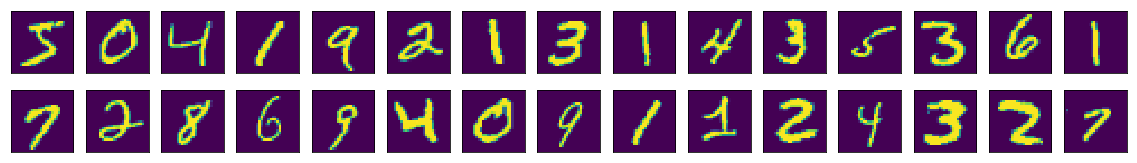

In [4]:
# Show first thirty images from the training set
showImages(x_train,30,15)

## Step3: Create Keras convolutional neural network
This uses a basic CNN architecture from the Keras examples.
The model layers are added sequentially:

**[Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)**
    It is a 2D convolutional layer that we use to process the 2D MNIST input images:
    * The first argument passed to the Conv2D() layer function is the number of output channels – in this case we have 32 output channels. 
    * `kernel_size`, is the size of the sampling moving window, here a 3x3 aperture
    * the activation function is a rectified linear unit (ReLU) 
    * The shape (size: height, width, color depth) of the input is inferred from the training set image size.
    Noe that declaring the input shape is only required of the first layer, Keras will then work out the size of the tensors flowing through the model (automatic shape inference). We start with 26x26 pixels and 32 bit colors

**[MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)**:
    Reduction matrix, here we halve each dimension, resulting shape will be a 13x13x32 matrix

**[Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)**:
    Transform the input's shape n*c*h*w into a n*(c*h*w) vector) yields 13*13*32=5408 outputs as a flat vector

**[Dense(128,relu)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)**:
    A layer where each neuron is linked to each ones of the next layer. This layer is set to yield 128 outputs

**[DropOut](https://www.tensorflow.org/api_docs/python/tf/keras/layers/DropOut)**:
    Freeze some neurons to avoid overfitting. *Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.*

**[Dense(10,SoftMax)]**
    Layer to transform a scoring distribution into a probability distribution, with 10 outputs for our 10 digits. *The [softmax](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) function normalizes ('squashes') a K-dimensional vector of real values to a K-dimensional vector of real values, where each entry is in the range (0, 1),[a] and all the entries add up to 1.

**Optimizer parameters**:
    * lr: Learning rate, interval used for the gradient descent algorithm
    * **[loss]()**: Cost/loss function used for this neural network, here we use *Categorical cross entropy*

In [5]:
# Create Keras convolutional neural network - basic architecture from Keras examples
k.set_learning_phase(1)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=x_train.shape[1:]))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

# Set Hyperparameters
###Optimizer='adam'
Optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Initialize and compile:
model.compile(optimizer=Optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               692352    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________________________________________


After execution, we display a summary of our ANN model as shown in the cell result above.
Note the total number of weights & bias to be determined during the training sequence and understand how complex can be to train very complex ANN with hundreds of layers.
Here we have 3 layers amounting to 320 + 692352 + 1290 = 693962 parameters.

##  Step 4: Build,test & run the CNN model
Now we are ready to train our defined model against the MNIST training data.

We train the model on test set.   
The processing time will depending on the configuration of your environment.
You will see the various iterations and epochs with an accuracy & loss values associated to the model.

In [6]:
%%time
# Train the Classifier wrapper
Original_Classifier = KerasClassifier((0,1),model,use_logits=False)
Original_Classifier.fit(x_train, y_train, batch_size=128, nb_epochs=10)
scores = model.evaluate(x_test, y_test, verbose=1)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/10
469/468 [==============================] - 29s 63ms/step - loss: 0.2662 - acc: 0.9197
Epoch 2/10
469/468 [==============================] - 31s 65ms/step - loss: 0.0830 - acc: 0.9753
Epoch 3/10
469/468 [==============================] - 30s 64ms/step - loss: 0.0570 - acc: 0.9828
Epoch 4/10
469/468 [==============================] - 30s 65ms/step - loss: 0.0451 - acc: 0.9866
Epoch 5/10
469/468 [==============================] - 30s 64ms/step - loss: 0.0379 - acc: 0.9888
Epoch 6/10
469/468 [==============================] - 30s 63ms/step - loss: 0.0307 - acc: 0.9904
Epoch 7/10
469/468 [==============================] - 32s 67ms/step - loss: 0.0270 - acc: 0.9921
Epoch 8/10
469/468 [==============================] - 29s 62ms/step - loss: 0.0254 - acc: 0.9925
Epoch 9/10
469/468 [==============================] - 29s 62ms/step - loss: 0.0217 - acc: 0.9937
Epoch 10/10
10000/10000 [==============================] - 2s 219us/step
Baseline Error: 1.50%
CPU times: user 17min 46s, sys: 

##  Step 5: Analyse results
Finally let's test which digits are properly or not recognized by our generated model.   
We run `predict`ions on the images present in the test set and compare the predicted digit with the actual (annotated) one

We show the 30 first wrongly predicted images

Original images with Original  classifier succcess rate: 98.58%


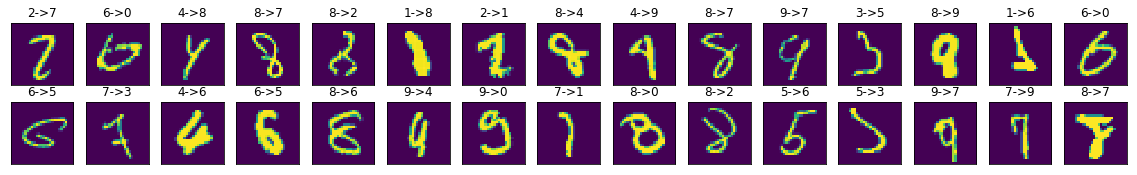

In [7]:
# Test the classifier against fresh test data
predictions = Original_Classifier.predict(x_test)
# count false predictions and display 30 first mismatches
AccOriOri = showImagesAccuracy('Original images with Original ',x_test, y_test, predictions, 30)

## Step 6: Enhancing the model with ART

Thanks to the ART toolbox we have a full set of attacks & defense available to assess our classifier.
The ART library contains implementations of the following evasion attacks:
    * DeepFool (Moosavi-Dezfooli et al., 2015)
    * Fast Gradient Method (Goodfellow et al., 2014)
    * Basic Iterative Method (Kurakin et al., 2016)
    * Projected Gradient Descent (Madry et al., 2017)
    * Jacobian Saliency Map (Papernot et al., 2016)
    * Universal Perturbation (Moosavi-Dezfooli et al., 2016)
    * Virtual Adversarial Method (Miyato et al., 2015)
    * C&W Attack (Carlini and Wagner, 2016)
    * NewtonFool (Jang et al., 2017)

We will now start challenging our Hand Digit recognition model.

We'll use one of the above implementations, the Fast Gradient Method and assess our model against it.
MNIST training dataset is made of 60000 samples so to save some time let's create only 10% of modified data from it.

We apply the `FastGradientMethod` from ART toolbox to the MNIST images and then evaluate how our model scores using the original classifier

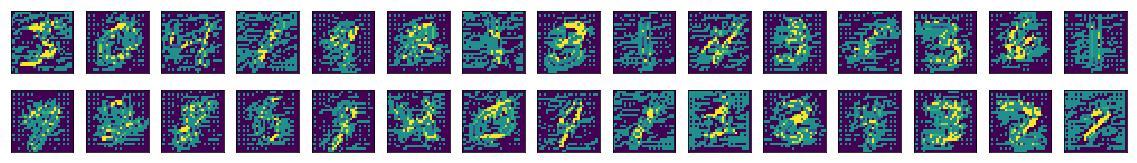

In [8]:
# Create modified train sub dataset (100 first images) with noise on it.
# Craft adversarial samples with the FastGradient Method
adv_crafter_FGM = FastGradientMethod(Original_Classifier, eps=0.5)

# generate one tenth of images for training set and full for test set
x_train_adv_FGM = adv_crafter_FGM.generate(x_train[:(len(x_train)//10)])
x_test_adv_FGM = adv_crafter_FGM.generate(x_test[:len(x_test)])
showImages(x_train_adv_FGM,30,15)

Now that we have generated the perturbated images, let's assess our original classifier against this new training dataset

Adversarial FastGradient Images with Original  classifier succcess rate: 11.34%


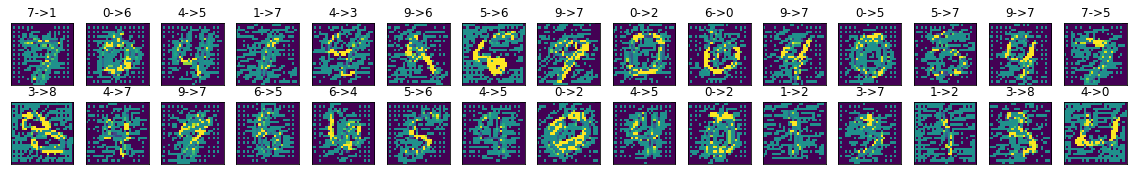

In [9]:
# Challenge the Classifier with FastGradient modified dataset
predictions = Original_Classifier.predict(x_test_adv_FGM[:len(x_test_adv_FGM)])
AccFGMOri=showImagesAccuracy('Adversarial FastGradient Images with Original ',x_test_adv_FGM, y_test, predictions, 30,15)

The quality of our model goes down from above 98% accuracy to less than 8%

## Step 7: Enhancing the performance of classification
You can refer to the ART gitHub writeup to get a full sample on how to train more efficiently your classifier.

In this tutorial, we'll explore only one, so that we can observe rapidly ART's added value.

To do so let's enrich our initial training data with the one we just created for the Fast Method Gradient Attack, and then retrain the same ANN model structure

In [10]:
# Data augmentation: expand the training set with the adversarial samples
x_train_robust = np.append(x_train, x_train_adv_FGM, axis=0)
y_train_robust = np.append(y_train, y_train[:len(x_train_adv_FGM)], axis=0)
x_test_robust = np.append(x_test, x_test_adv_FGM[:len(x_test_adv_FGM)], axis=0)
y_test_robust = np.append(y_test, y_test[:len(x_test_adv_FGM)], axis=0)

# Retrain the CNN on the extended dataset
model.compile(loss='categorical_crossentropy', optimizer=Optimizer, metrics=['accuracy'])

In [11]:
%%time
# and train a classifier
Robust_Classifier = KerasClassifier((0,1),model,use_logits=False)
Robust_Classifier.fit(x_train_robust, y_train_robust, nb_epochs=10, batch_size=128)

Epoch 1/10
516/515 [==============================] - 31s 60ms/step - loss: 0.1553 - acc: 0.9553
Epoch 2/10
516/515 [==============================] - 29s 56ms/step - loss: 0.0545 - acc: 0.9840
Epoch 3/10
516/515 [==============================] - 30s 59ms/step - loss: 0.0392 - acc: 0.9888
Epoch 4/10
516/515 [==============================] - 30s 59ms/step - loss: 0.0348 - acc: 0.9899
Epoch 5/10
516/515 [==============================] - 29s 56ms/step - loss: 0.0354 - acc: 0.9903
Epoch 6/10
516/515 [==============================] - 29s 56ms/step - loss: 0.0305 - acc: 0.9912
Epoch 7/10
516/515 [==============================] - 30s 58ms/step - loss: 0.0299 - acc: 0.9912
Epoch 8/10
516/515 [==============================] - 29s 56ms/step - loss: 0.0292 - acc: 0.9914
Epoch 9/10
516/515 [==============================] - 30s 59ms/step - loss: 0.0276 - acc: 0.9921
Epoch 10/10
516/515 [==============================] - 28s 55ms/step - loss: 0.0287 - acc: 0.9913
CPU times: user 18min 39s, sy

## Step 8: Check retrained classifier on modified dataset

Adversarial FastGradient Images with Robust classifier succcess rate: 94.67%


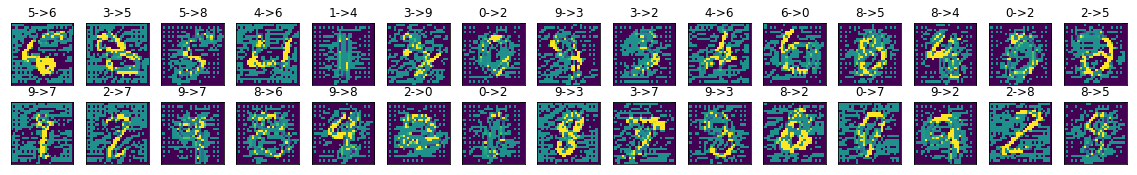

In [12]:
# Challenge the Robust Classifier with FastGradient modified dataset
predictions = Robust_Classifier.predict(x_test_adv_FGM[:len(x_test_adv_FGM)])
AccFGMRob = showImagesAccuracy('Adversarial FastGradient Images with Robust',x_test_adv_FGM, y_test, predictions, 30)

## Step 9: Check retrained classifier on original dataset

Original Images with Robust classifier succcess rate: 98.36%


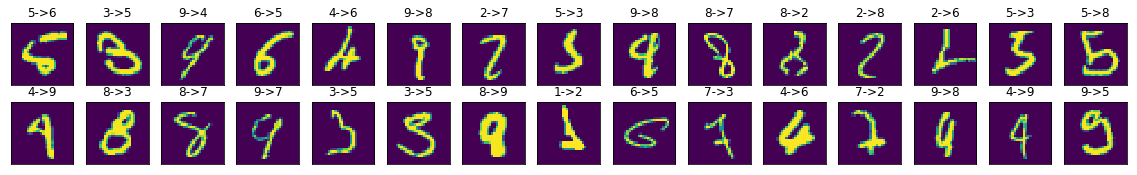

In [15]:
# Test the Robust Classifier with original dataset
predictions = Robust_Classifier.predict(x_test)
# count false predictions and display 30 first mismatches
AccOriRob = showImagesAccuracy('Original Images with Robust',x_test, y_test, predictions, 30)

# Conclusion